In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.3.0


In [2]:
#텐서플로의 표준 데이터 파일 포맷으로 저장된 데이터를 활용함
MONET_FILENAMES = tf.io.gfile.glob(str('bin'+ '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('bin' + '/photo_tfrec/*.tfrec'))

In [3]:
IMAGE_SIZE = [256, 256]
#이미지 사이즈는 256 * 256 *3(채널)임

In [4]:
#채널을 3으로 설정한 뒤 이미지를 -1에서 1로 정규화 시킨다.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
#데이터를 불러온다.
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
#생성자 생성 방법은 U-Net을 활용했으며 4개의 다운샘플링 레이어와 4개의 업샘플링 레이어로 구성된다
#활성화 함수는 간단하게 ReLU함수를 활용했다.
def create_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu', input_shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(256,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(512,4, strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))       
    model.add(layers.Conv2DTranspose(256, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(128, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose( 64, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(  3, 4, strides=2,padding='same', kernel_initializer=initializer, activation='tanh', use_bias=False))          
    return model

In [9]:
#판별자의 경우 인풋 이미지를 다운샘플링에서 출력한다.
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu', input_shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(256,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(1,4,strides=1, padding='valid', kernel_initializer=initializer, activation='relu',use_bias=False))
    return model

In [10]:
#두개의 생성자와 두개의 판별자를 생성한다.
with strategy.scope():
    monet_generator = create_generator() # transforms photos to Monet-esque paintings
    photo_generator = create_generator() # transforms Monet paintings to be more like photos

    monet_discriminator = create_discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = create_discriminator() # differentiates real photos and generated photos

In [11]:
#모델은 모넷의 그림을 사진으로 변형하고 사진을 모넷의 그림으로 변형한다.
#각각 다른 손실함수를 사용한다.
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [12]:
#첫번째 조건이었던 유효성을 검사하는 함수이다.
#완벽한 판별자는 실제이미지에서 1을 반환하고 가짜이미지에서 0을 반환할것이다.
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [13]:
#판별자에서 1을 반환한것과 생성된 이미지를 비교한다.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [14]:
#두번째 조건인 재구성을 손실 함수로 바꾼 함수로 두번 적용시킨 사진은 원본과 동일해야한다
#두번 바뀐것과 원본의 차이를 손실함수로 해서 출력한다.
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [15]:
#세번째 조건인 동일성일 손실함수로 바꿨다. 
#목표 도메인에서 목표 도메인으로 처리하는 모델을 적용하면 같은 이미지가 나와야한다
#생성된 이미지와 원본이미지의 차이를 손실함수로 해서 출력한다.
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [16]:
#Adam optimizer를 사용한다.
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
#모델을 생성한뒤 정해진 손실함수를 기반으로 
# train_step 마다 학습한다.
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )


In [18]:
#너무나 오래걸렸기에 5에폭을 사용해서 학습한다.
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5
300/300 [==============================] - 456s 2s/step - monet_gen_loss: 6.9111 - photo_gen_loss: 7.0605 - monet_disc_loss: 0.4944 - photo_disc_loss: 0.5003
Epoch 2/5
300/300 [==============================] - 450s 2s/step - monet_gen_loss: 6.0025 - photo_gen_loss: 6.0951 - monet_disc_loss: 0.4259 - photo_disc_loss: 0.4940
Epoch 3/5
300/300 [==============================] - 451s 2s/step - monet_gen_loss: 5.7620 - photo_gen_loss: 5.8119 - monet_disc_loss: 0.6164 - photo_disc_loss: 0.5505
Epoch 4/5
300/300 [==============================] - 444s 1s/step - monet_gen_loss: 5.4432 - photo_gen_loss: 5.4307 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.5663
Epoch 5/5
300/300 [==============================] - 491s 2s/step - monet_gen_loss: 5.0422 - photo_gen_loss: 5.0307 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.5447


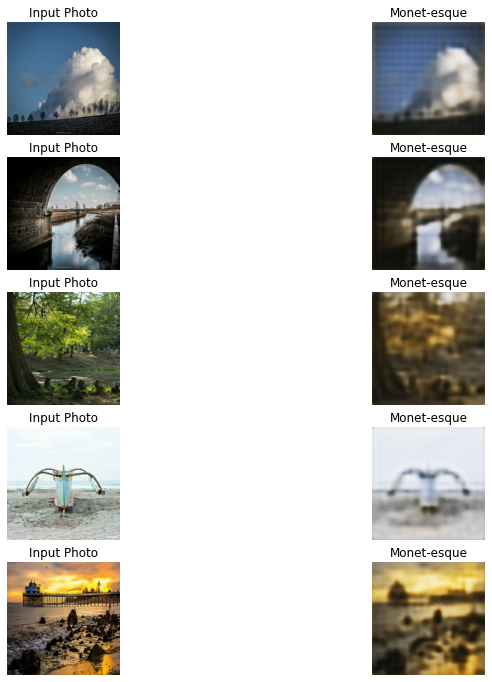

In [19]:
#학습된 생성자를 사용해 이미지를 비교한다.
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [20]:
import PIL

In [21]:
#마지막으로 사진이미지를 생성자를 이용하여 모넷풍으로 변환시킨다.
#에폭이 적고 가장 원초적인 CycleGAN모델을 활용했기에 발전이 필요한 결과를 얻었다.
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("bin/" + str(i) + ".jpg")
    i += 1